In [1]:
source("https://bioconductor.org/biocLite.R")
biocLite('Biobase')
biocLite('GEOquery')

library(NMF)
library(matrixStats)
library(Biobase)
library(GEOquery)
library(genefilter)

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) 'Biobase'


package 'Biobase' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\gwegwe\AppData\Local\Temp\RtmpS0iTqk\downloaded_packages


Old packages: 'assertthat', 'jsonlite', 'backports', 'broom', 'cluster',
  'colorspace', 'curl', 'data.table', 'DBI', 'digest', 'forcats', 'ggplot2',
  'lattice', 'Matrix', 'mgcv', 'nlme', 'openssl', 'pbdZMQ', 'pbkrtest',
  'psych', 'Rcpp', 'RcppEigen', 'readr', 'repr', 'rmarkdown', 'rprojroot',
  'selectr', 'shiny', 'sourcetools', 'SparseM', 'stringi', 'stringr',
  'survival', 'tibble', 'tidyr', 'tidyverse', 'xml2', 'zoo'
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) 'GEOquery'


package 'GEOquery' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\gwegwe\AppData\Local\Temp\RtmpS0iTqk\downloaded_packages


Old packages: 'assertthat', 'jsonlite', 'backports', 'broom', 'cluster',
  'colorspace', 'curl', 'data.table', 'DBI', 'digest', 'forcats', 'ggplot2',
  'lattice', 'Matrix', 'mgcv', 'nlme', 'openssl', 'pbdZMQ', 'pbkrtest',
  'psych', 'Rcpp', 'RcppEigen', 'readr', 'repr', 'rmarkdown', 'rprojroot',
  'selectr', 'shiny', 'sourcetools', 'SparseM', 'stringi', 'stringr',
  'survival', 'tibble', 'tidyr', 'tidyverse', 'xml2', 'zoo'
Warning message:
"package 'NMF' was built under R version 3.3.3"Loading required package: pkgmaker
Warning message:
"package 'pkgmaker' was built under R version 3.3.3"Loading required package: registry

Attaching package: 'pkgmaker'

The following object is masked from 'package:base':

    isNamespaceLoaded

Loading required package: rngtools
Warning message:
"package 'rngtools' was built under R version 3.3.3"Loading required package: cluster
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: windows] | Cores 3/4
Warning message:
"package 'matrixStats'

In [2]:
VdNMF <- function( 
    gse,                        #GSE dataset to extract expression values from.  21501 = Pancreatic cancer microarrays.
    k = 14,                     #User's guess for a reasonable number of factorrs.
    kLow = k - 2,               #Lower bound for the range of factors tested by nmf.
    kHigh = k + 2,              #Upper bound for the range of factors tested by nmf.
    numRuns = 10,               #Number of NMF runs.  This can also be changed to run to convergence.
    nmfMethod = 'brunet',       #Specific NMF algorithm to use.  See NMF library for options.  

    #numGenes = 10000,             #TESTING VARIABLE: restricted number of genes for run time.
    topGeneCutoff = 50,        #TESTING VARIABLE: restricted number of top genes for run time.
    numSamples = ncol(gse[[1]])
    )
    
    {
    exprSetGSE <- gse[[1]]
    
    inputExprs <- exprs(exprSetGSE)
    f_inputExprs <- inputExprs[rowMeans(inputExprs) > 0.5,]  ##TESTING FILTER: restricted number of genes for run time.
    unlogExprs <- (2^f_inputExprs) + 1
    nnExprs <- log2(unlogExprs)
    
    #nmfRes <- nmf(subNnExprs, seq(kLow, kHigh, 1), nrun = numRuns, method=nmfMethod, .opt = "v")
    
    nmfRes <- nmf(nnExprs, seq(kLow, kHigh, 1), nrun = numRuns, method=nmfMethod, .opt = "v")
    
    
    plot(nmfRes)

    #Cophenetic coefficient is an expression (0-1) of how consistently samples are assigned to the same cluster over
    #iterations of the NMF.
    
    sumNMF <- summary(nmfRes)
    kList <- seq(kLow, kHigh, 1)
    cophenetic <- sumNMF[,"cophenetic"]
    peak <- rep(0, length(kList))

    for (i in 2:(length(cophenetic) - 1)) if (cophenetic[i-1] < cophenetic[i] & cophenetic[i] > cophenetic[i+1]) {
        peak[i] <- 1
    }

    peaks <- kList[peak == 1]
    k <- rev(peaks)[1]
        
    consensusmap(nmfRes)

    print(paste("Suggested k value (number of factors):", k))
    
    #return(subNnExprs)
    return(nnExprs)
}



In [3]:
#retrieve specified dataset, convert to nonnegative format, and run initial NMF to determine appropriate k value.
gseNum = 'GSE21501'

gse <- getGEO(gseNum, GSEMatrix=TRUE)
exprSetGSE <- gse[[1]]

https://ftp.ncbi.nlm.nih.gov/geo/series/GSE21nnn/GSE21501/matrix/
OK
Found 1 file(s)
GSE21501_series_matrix.txt.gz
File stored at: 
C:\Users\gwegwe\AppData\Local\Temp\RtmpS0iTqk/GPL4133.soft
Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
"not all columns named in 'colClasses' exist"

Compute NMF rank= 12  ... + measures ... OK
Compute NMF rank= 13  ... + measures ... OK
Compute NMF rank= 14  ... + measures ... OK
Compute NMF rank= 15  ... + measures ... OK
Compute NMF rank= 16  ... + measures ... OK
[1] "Suggested k value (number of factors): 14"


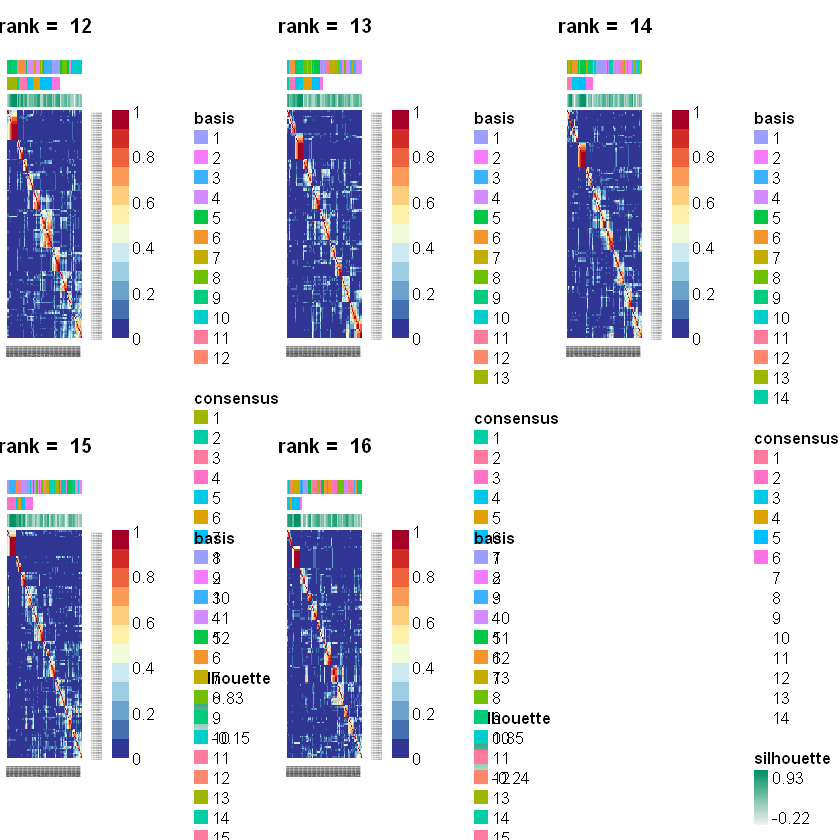

In [4]:
subsetGenes = VdNMF(gse)

In [5]:
VdNMFTopGenes <- function(
    #Returns top genes (default 50) differentiating factors.  Top genes are identified by their
    exprsSet,
    k = 14,                     #Number of factors for NMF.
    topGeneCutoff = 50,        #Number of top genes to return.
    nmfMethod = 'brunet',
    
    numGenes = 500,            #TESTING VARIABLE: restricted number of top genes for run time.
    numSamples = 132
    )

    {
    nmfRes <- nmf(exprsSet, k, method= nmfMethod)
    nmfLsRes <- nmf(exprsSet, k, method="snmf/l", seed = nmfRes)
                
    #NMF factors matrix V into matrices W (weights) and H (basis).
    #In this case, S = W (sample loadings) and G = H (gene loadings).
    S <- coef(nmfLsRes)
    G <- basis(nmfLsRes)

    #Normalize both G and S to make the column means of G = 1
    for (i in 1:14){
        colMean <- mean(G[,i])
        G[,i] <- G[,i] / colMean
        S[i,] <- S[i,] * colMean
    }
    #diff_G is a matrix of differences between gene loading values (G) and the max loading value for that gene (outside of the present)
    #column.

    diffG <- G

    for (j in 1:14){
        for (i in 1:numGenes){
            diffG[i, j] <- diffG[i,j] - max(G[i, -j]) 
        }
    }

    topGeneCutoff = 50
    numSamples = 132

    topGenes <- mat.or.vec(topGeneCutoff,k)

    for(i in 1:14){
        topGenes[,i]<-rownames(head(diffG[order(diffG[,i], decreasing=TRUE),0],topGeneCutoff))  
    }
        
    distanceMatrix <- dist(t(topGenes))
    hierClust <- hclust(distanceMatrix, method="complete")
    topGenes <- topGenes[,hierClust$order]
    
    distanceMatrix <- dist(topGenes)
    hierClust <- hclust(distanceMatrix, method="complete")
    topGenes <- topGenes[hierClust$order,]
    
    return(topGenes)         
        
}

In [7]:
write.csv(subsetGenes, 'subsetgenes.csv')

In [8]:
topGenes = VdNMFTopGenes(exprsSet = subsetGenes)

In [10]:
VdNMFAnnotate <- function( 
    
    #Converts the probe IDs to associated genes using feature data extracted from the GSE-derived expressionset object.
    
    exprSet,                       #Expression set object to extract annotation from
    topGenes                       #Matrix of top genes derived from NMF.   
    )
    {
    
    
    fdata = fData(exprSet)
    probeIDtoGene <- matrix(fdata$GENE_SYMBOL[as.integer(topGenes)],nrow = nrow(topGenes), ncol= ncol(topGenes))
    
    return(probeIDtoGene)  
}

In [11]:
annot <- VdNMFAnnotate(exprSetGSE, topGenes)

In [13]:
dfAnnot <- as.data.frame(annot)

In [14]:
dfAnnot

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
,ELA3B,,COL3A1,,,C1orf173,HBB,LINCR,MARCO,SMPD3,GP2,EPB41L4A,
CXCL13,SFRP4,S100A2,GREM1,,,CABP7,SYNPO2,GCG,S100A8,ANXA10,,OLFM4,
CXCL9,COL10A1,PSCA,POSTN,ZFPM1,ARHGEF15,,SPARCL1,CHGB,WDR69,CLRN3,PRSS2,,
GBP5,CDH11,,COL1A2,CDH24,CEBPB,,CXCL12,NEUROD1,AQP9,APOBEC1,KCNJ16,CAPN8,
ADAMDEC1,SPARCL1,GPR87,COL11A1,WNT6,RHO,PPM1F,DES,KCNJ16,FCGR3A,TSPAN8,PNLIP,MMP7,
,COL1A2,SLPI,,LOC439951,,PLCB2,,CLDN10,CXCL5,MUPCDH,TEX11,CFTR,
CCR5,SULF1,MUC4,COL5A2,,NACC1,,ANGPTL1,CHGB,HBB,C1orf125,GATM,PSCA,
HLA-DOA,CXCL14,,COL1A2,,HRASLS5,,CXCL12,IAPP,LILRB3,BTNL3,SLC4A4,LOC151878,
CR2,PDGFRB,AREG,MNDA,,TMEM201,,SORBS1,COLEC11,AIM2,TFF2,REG3G,B2M,
KIAA0125,COL1A2,PLAT,,BHLHE23,,LOC286272,IGF1,TM4SF4,VWF,,CTRB1,ADAM28,


In [15]:
write.csv(annot, 'annot.csv')